# **Hipótese H₁:** Prompts mais específicos melhoram o desempenho em ambos os idiomas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, chi2
import warnings
import re

In [2]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [3]:
PATH_BLIND = "../../data/processed/blind_pool_cross_prompt.csv"
PATH_ANALYSIS = "../../data/analysis/complete_analysis.csv"
HIERARQUIA_PROMPTS = ['minimum', 'contextual', 'detailed', 'structured'] 
NIVEL_DE_CONFIANCA = 0.95

In [4]:
df_blind = pd.read_csv(PATH_BLIND)
df_blind.head(2)

,evaluation_id,question_id,sample_n,domain,language,model,comparison,response_A,prompt_level_of_A,response_B,prompt_level_of_B
0,CG001_1_General Knowledge_gemini-1.5-pro-lates...,CG001,1,General Knowledge,en,gemini-1.5-pro-latest,minimum_vs_contextual,"World War I, a complex and devastating conflic...",minimum,"World War I, a conflict that engulfed Europe a...",contextual
1,CG001_1_General Knowledge_gemini-1.5-pro-lates...,CG001,1,General Knowledge,en,gemini-1.5-pro-latest,minimum_vs_detailed,"World War I, a conflict that engulfed Europe a...",detailed,"World War I, a complex and devastating conflic...",minimum


In [5]:
df_analysis = pd.read_csv(PATH_ANALYSIS)
df_analysis.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,human_winner,domain,language_context,sample_n
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,A,5.00,A,A,Technical,EN vs PT,1
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,Tie,4.75,A,B,General Knowledge,EN vs PT,4


In [6]:
df_merged = pd.merge(
    df_analysis,
    df_blind,
    on='evaluation_id',
    how='inner',
    suffixes=('', '_blind')
)

cols_para_remover = [col for col in df_merged.columns if col.endswith('_blind')]
df_merged = df_merged.drop(columns=cols_para_remover)

print("Shape final:", df_merged.shape)
df_merged.head(2)

Shape final: (500, 23)


,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,...,human_winner,domain,language_context,sample_n,question_id,language,model,comparison,prompt_level_of_A,prompt_level_of_B
0,CG004_3_General Knowledge_gemini-1.5-pro-lates...,The Proclamation of the Republic in Brazil in ...,The Proclamation of the Republic in Brazil on ...,"{\n ""winner"": ""B"",\n ""general_justificat...","Based on the provided responses, the winner is...","{\n ""winner"": ""B"",\n ""general_justification...",B,4.75,B,4.75,...,B,General Knowledge,EN,3,CG004,en,gemini-1.5-pro-latest,contextual_vs_structured,structured,contextual
1,CG002_3_General Knowledge_sabia-3.1_detailed_v...,"The fall of the Berlin Wall on November 9, 19...",The fall of the Berlin Wall in 1989 is signif...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""A"",\n""general_justification"": ""A...","{\n ""winner"": ""A"",\n ""general_justifica...",A,4.75,A,4.75,...,A,General Knowledge,EN,3,CG002,en,sabia-3.1,detailed_vs_structured,structured,detailed


In [7]:
df_prompts = df_merged[
            df_merged['prompt_level_of_A'].notna() & 
            df_merged['prompt_level_of_B'].notna()
        ].copy()

In [8]:
# Normaliza nomes dos prompts
df_prompts['prompt_level_of_A'] = df_prompts['prompt_level_of_A'].str.lower()
df_prompts['prompt_level_of_B'] = df_prompts['prompt_level_of_B'].str.lower()
HIERARQUIA_PROMPTS = [p.lower() for p in HIERARQUIA_PROMPTS]

In [9]:
print(f"Pares de comparação de prompts: {len(df_prompts)}\n")
print(f"Distribuição por idioma:")
print(df_prompts['language'].value_counts())

Pares de comparação de prompts: 500

Distribuição por idioma:
language
en    258
pt    242
Name: count, dtype: int64


## Distribuição Completa de Resultados (Vitórias, Derrotas, Empates)

In [10]:
def calcular_distribuicao_resultados(df, p_menos, p_mais, idioma, coluna_vencedor='gold_winner'):
    """
    Calcula a distribuição completa de resultados entre dois prompts.
    
    Returns:
        dict com proporções de vitórias do menos específico, mais específico, e empates
    """
    # Filtra comparações relevantes
    subset = df[
        (df['language'] == idioma) & 
        (((df['prompt_level_of_A'] == p_menos) & (df['prompt_level_of_B'] == p_mais)) |
         ((df['prompt_level_of_A'] == p_mais) & (df['prompt_level_of_B'] == p_menos)))
    ]
    
    n = len(subset)
    if n == 0:
        return None
    
    vitorias_menos = 0
    vitorias_mais = 0
    
    for _, row in subset.iterrows():
        winner = row[coluna_vencedor]
        if winner == 'A':
            if row['prompt_level_of_A'] == p_mais:
                vitorias_mais += 1
            else:
                vitorias_menos += 1
        elif winner == 'B':
            if row['prompt_level_of_B'] == p_mais:
                vitorias_mais += 1
            else:
                vitorias_menos += 1
    
    empates = n - vitorias_menos - vitorias_mais
    
    # Calcula intervalo de confiança para proporção de vitórias do mais específico
    # Usando aproximação normal para proporção
    p_mais_spec = vitorias_mais / n
    se = np.sqrt(p_mais_spec * (1 - p_mais_spec) / n)
    z = norm.ppf((1 + NIVEL_DE_CONFIANCA) / 2)
    ic_lower = max(0, p_mais_spec - z * se)
    ic_upper = min(1, p_mais_spec + z * se)
    
    return { 
        'prompt_menos_especifico': p_menos,
        'prompt_mais_especifico': p_mais,
        'vitorias_menos': vitorias_menos,
        'vitorias_mais': vitorias_mais,
        'empates': empates,
        'prop_vitorias_menos': vitorias_menos / n,
        'prop_vitorias_mais': vitorias_mais / n,
        'prop_empates': empates / n,
        'n_total': n,
        'ic_95_lower': ic_lower,
        'ic_95_upper': ic_upper
    }

In [11]:
resultados_distribuicao = []

for i in range(len(HIERARQUIA_PROMPTS)):
    for j in range(i + 1, len(HIERARQUIA_PROMPTS)):
        p_menos, p_mais = HIERARQUIA_PROMPTS[i], HIERARQUIA_PROMPTS[j]
        
        for lang in ['en', 'pt']:
            resultado = calcular_distribuicao_resultados(df_prompts, p_menos, p_mais, lang)
            if resultado:
                resultado['idioma'] = lang.upper()
                resultado['comparacao'] = f"{p_mais.capitalize()} vs {p_menos.capitalize()}"
                resultados_distribuicao.append(resultado)

df_distribuicao = pd.DataFrame(resultados_distribuicao)

In [12]:
print("--- Distribuição de Resultados por Comparação: ---\n")
df_print = df_distribuicao[[
    'comparacao', 'idioma', 'n_total',
    'prop_vitorias_menos', 'prop_vitorias_mais', 'prop_empates',
    'ic_95_lower', 'ic_95_upper'
]].copy()

df_print.columns = [
    'Comparação', 'Idioma', 'N',
    'Vit. Menos Espec.', 'Vit. Mais Espec.', 'Empates',
    'IC 95% Lower', 'IC 95% Upper'
]

for col in df_print.columns[3:]:
    df_print[col] = df_print[col].map('{:.1%}'.format)

df_print.head(20)

--- Distribuição de Resultados por Comparação: ---



,Comparação,Idioma,N,Vit. Menos Espec.,Vit. Mais Espec.,Empates,IC 95% Lower,IC 95% Upper
0,Contextual vs Minimum,EN,41,22.0%,41.5%,36.6%,26.4%,56.5%
1,Contextual vs Minimum,PT,44,50.0%,13.6%,36.4%,3.5%,23.8%
2,Detailed vs Minimum,EN,39,41.0%,30.8%,28.2%,16.3%,45.3%
3,Detailed vs Minimum,PT,44,40.9%,29.5%,29.5%,16.1%,43.0%
4,Structured vs Minimum,EN,51,43.1%,37.3%,19.6%,24.0%,50.5%
5,Structured vs Minimum,PT,50,42.0%,42.0%,16.0%,28.3%,55.7%
6,Detailed vs Contextual,EN,36,38.9%,22.2%,38.9%,8.6%,35.8%
7,Detailed vs Contextual,PT,30,26.7%,40.0%,33.3%,22.5%,57.5%
8,Structured vs Contextual,EN,43,37.2%,41.9%,20.9%,27.1%,56.6%
9,Structured vs Contextual,PT,45,46.7%,40.0%,13.3%,25.7%,54.3%


In [13]:
print("RESUMO GERAL:")
print(f"  Taxa média de vitórias do prompt mais específico: {df_distribuicao['prop_vitorias_mais'].mean():.1%}")
print(f"  Taxa média de empates: {df_distribuicao['prop_empates'].mean():.1%}")
print(f"  Comparações onde mais específico vence > 50%: {(df_distribuicao['prop_vitorias_mais'] > 0.5).sum()}/{len(df_distribuicao)}")

RESUMO GERAL:
  Taxa média de vitórias do prompt mais específico: 36.0%
  Taxa média de empates: 26.2%
  Comparações onde mais específico vence > 50%: 0/12


Em nenhuma das 12 comparações diretas (6 pares x 2 idiomas), a proporção de vitórias do prompt mais específico ultrapassou 50% (coluna 'Vit. Mais Espec.').

**EN:** Os resultados são mistos. Por exemplo, Contextual vence Minimum (41.5%), e Structured vence Detailed (47.9%), mas Minimum vence Detailed (30.8%%), e Contextual vence Detailed (38.9%). Não há uma tendência clara de aumento de vitórias com a especificidade.

**PT:** Os resultados também são inconsistentes. Notavelmente, Minimum vence Contextual (50.0%) e Detailed (40.9%). Detailed vence Contextual (40.0%), e Structured vence Detailed (44.8%). Novamente, não há uma tendência clara e Minimum parece forte.

**Empates:** A taxa média de empates é alta, indicando que em muitas comparações não houve diferença clara de qualidade percebida.

In [14]:
df_plot = []
for _, row in df_distribuicao.iterrows():
    df_plot.append({
        'Comparação': row['comparacao'],
        'Idioma': row['idioma'],
        'Tipo': f"Vit. {row['prompt_menos_especifico'].capitalize()}",
        'Proporção': row['prop_vitorias_menos']
    })
    df_plot.append({
        'Comparação': row['comparacao'],
        'Idioma': row['idioma'],
        'Tipo': f"Vit. {row['prompt_mais_especifico'].capitalize()}",
        'Proporção': row['prop_vitorias_mais']
    })
    df_plot.append({
        'Comparação': row['comparacao'],
        'Idioma': row['idioma'],
        'Tipo': 'Empate',
        'Proporção': row['prop_empates']
    })

df_plot = pd.DataFrame(df_plot)

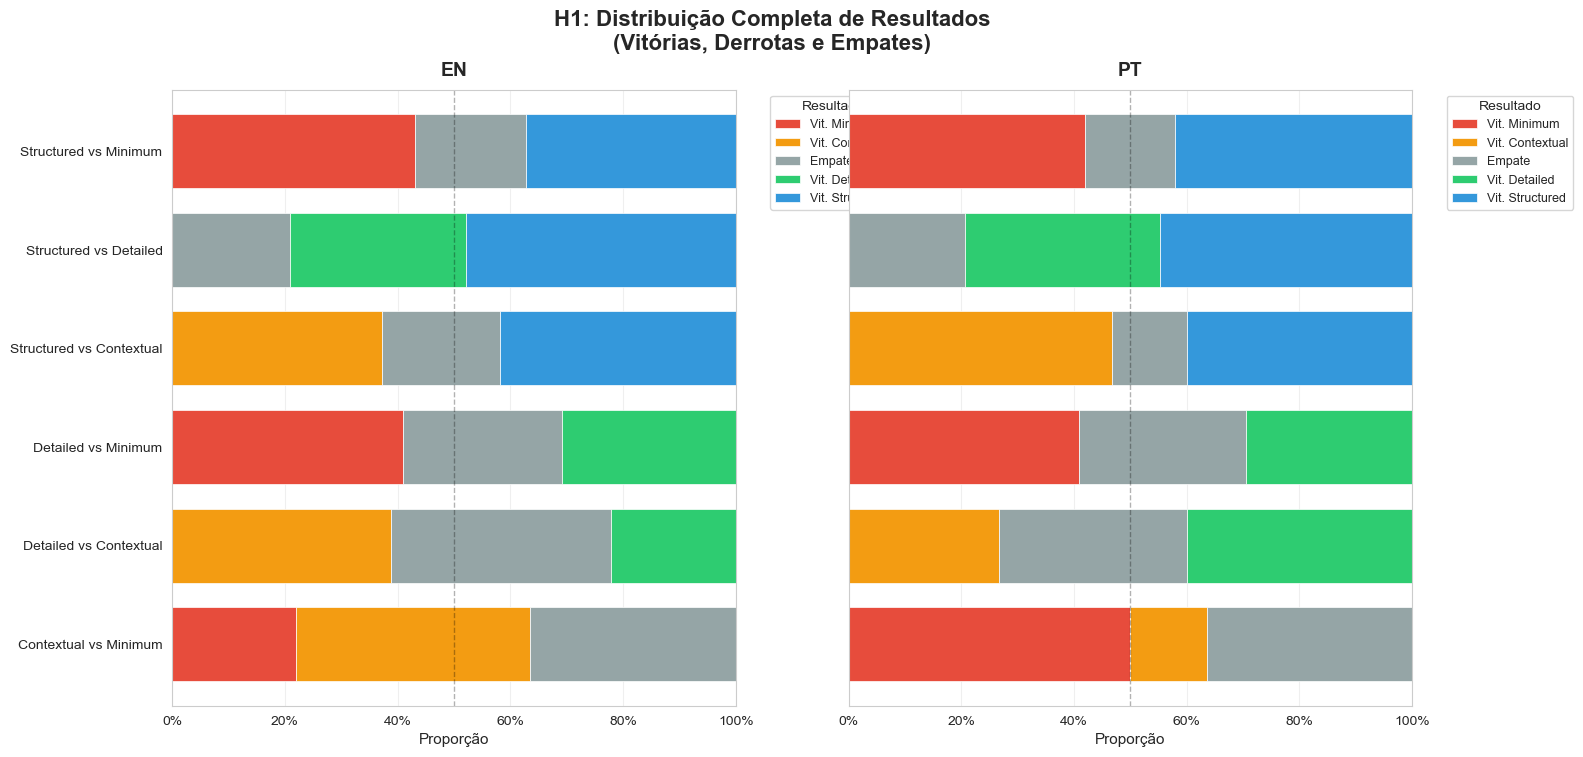

In [15]:
# Cria gráfico de barras empilhadas
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
fig.suptitle('H1: Distribuição Completa de Resultados\n(Vitórias, Derrotas e Empates)', 
                fontsize=16, weight='bold', y=0.98)

# Paleta de cores
cores_base = {
    'minimum': '#e74c3c',
    'contextual': '#f39c12', 
    'detailed': '#2ecc71',
    'structured': '#3498db'
}

for ax, lang in zip(axes, ['EN', 'PT']):
    df_lang = df_plot[df_plot['Idioma'] == lang]
    
    # Cria pivot para barras empilhadas
    pivot = df_lang.pivot_table(
        index='Comparação', 
        columns='Tipo', 
        values='Proporção',
        aggfunc='first'
    )
    
    # Ordena colunas: empates no meio
    cols_ordenadas = [c for c in pivot.columns if 'Vit.' in c and 'minimum' in c.lower()] + \
                    [c for c in pivot.columns if 'Vit.' in c and 'contextual' in c.lower()] + \
                    ['Empate'] + \
                    [c for c in pivot.columns if 'Vit.' in c and 'detailed' in c.lower()] + \
                    [c for c in pivot.columns if 'Vit.' in c and 'structured' in c.lower()]
    cols_ordenadas = [c for c in cols_ordenadas if c in pivot.columns]
    pivot = pivot[cols_ordenadas]
    
    # Define cores
    cores_plot = []
    for col in pivot.columns:
        if 'Empate' in col:
            cores_plot.append('#95a5a6')
        else:
            for nivel, cor in cores_base.items():
                if nivel in col.lower():
                    cores_plot.append(cor)
                    break
    
    pivot.plot(kind='barh', stacked=True, ax=ax, color=cores_plot, width=0.75, edgecolor='white', linewidth=0.5)
    
    ax.set_title(f'{lang}', fontsize=14, weight='bold', pad=10)
    ax.set_xlabel('Proporção', fontsize=11)
    ax.set_ylabel('')
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.axvline(0.5, color='black', linestyle='--', alpha=0.3, linewidth=1)
    ax.legend(title='Resultado', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(axis='x', alpha=0.3)

## Análise de Sensibilidade ao Tratamento de Empates

In [16]:
def calcular_vantagem_com_empates(row):
    """Calcula vantagem do prompt mais específico sob diferentes tratamentos de empates"""
    v_mais = row['vitorias_mais']
    v_menos = row['vitorias_menos']
    empates = row['empates']
    total = row['n_total']
    
    # Método 1: Empate = 0 (penaliza ambos)
    vantagem_empate_zero = v_mais / total
    
    # Método 2: Empate = 0.5 (meio ponto para cada)
    vantagem_empate_meio = (v_mais + 0.5 * empates) / total
    
    # Método 3: Ignorar empates (apenas decisões claras)
    if (v_mais + v_menos) > 0:
        vantagem_sem_empates = v_mais / (v_mais + v_menos)
    else:
        vantagem_sem_empates = np.nan
    
    return pd.Series({
            'empate_como_0': vantagem_empate_zero,
            'empate_como_0.5': vantagem_empate_meio,
            'ignorar_empates': vantagem_sem_empates
        })

In [17]:
df_sensibilidade = df_distribuicao.apply(calcular_vantagem_com_empates, axis=1)
df_sensibilidade = pd.concat([
    df_distribuicao[['comparacao', 'idioma', 'n_total', 'prop_empates']], 
    df_sensibilidade
], axis=1)

In [18]:
print("--- Vantagem do Prompt Mais Específico sob Diferentes Tratamentos ---\n")
df_print_sens = df_sensibilidade.copy()
df_print_sens['prop_empates'] = df_print_sens['prop_empates'].map('{:.1%}'.format)
for col in ['empate_como_0', 'empate_como_0.5', 'ignorar_empates']:
    df_print_sens[col] = df_print_sens[col].map('{:.1%}'.format)

df_print_sens.columns = [
    'Comparação', 'Idioma', 'N', '% Empates',
    'Empate=0', 'Empate=0.5', 'Sem Empates'
]
df_print_sens.head(20)

--- Vantagem do Prompt Mais Específico sob Diferentes Tratamentos ---



,Comparação,Idioma,N,% Empates,Empate=0,Empate=0.5,Sem Empates
0,Contextual vs Minimum,EN,41,36.6%,41.5%,59.8%,65.4%
1,Contextual vs Minimum,PT,44,36.4%,13.6%,31.8%,21.4%
2,Detailed vs Minimum,EN,39,28.2%,30.8%,44.9%,42.9%
3,Detailed vs Minimum,PT,44,29.5%,29.5%,44.3%,41.9%
4,Structured vs Minimum,EN,51,19.6%,37.3%,47.1%,46.3%
5,Structured vs Minimum,PT,50,16.0%,42.0%,50.0%,50.0%
6,Detailed vs Contextual,EN,36,38.9%,22.2%,41.7%,36.4%
7,Detailed vs Contextual,PT,30,33.3%,40.0%,56.7%,60.0%
8,Structured vs Contextual,EN,43,20.9%,41.9%,52.3%,52.9%
9,Structured vs Contextual,PT,45,13.3%,40.0%,46.7%,46.2%


In [19]:
# Análise do impacto
print("--- ANÁLISE DO IMPACTO DO TRATAMENTO ---")
for lang in ['EN', 'PT']:
    subset = df_sensibilidade[df_sensibilidade['idioma'] == lang]
    print(f"\n{lang}:")
    print(f"  Vantagem média (empate=0):     {subset['empate_como_0'].mean():.1%}")
    print(f"  Vantagem média (empate=0.5):   {subset['empate_como_0.5'].mean():.1%}")
    print(f"  Vantagem média (sem empates):  {subset['ignorar_empates'].mean():.1%}")
    print(f"  Diferença (0.5 vs 0):          +{(subset['empate_como_0.5'].mean() - subset['empate_como_0'].mean()):.1%}")
    print(f"  Diferença (sem vs 0):          +{(subset['ignorar_empates'].mean() - subset['empate_como_0'].mean()):.1%}")

--- ANÁLISE DO IMPACTO DO TRATAMENTO ---

EN:
  Vantagem média (empate=0):     36.9%
  Vantagem média (empate=0.5):   50.7%
  Vantagem média (sem empates):  50.7%
  Diferença (0.5 vs 0):          +13.8%
  Diferença (sem vs 0):          +13.8%

PT:
  Vantagem média (empate=0):     35.0%
  Vantagem média (empate=0.5):   47.4%
  Vantagem média (sem empates):  46.0%
  Diferença (0.5 vs 0):          +12.4%
  Diferença (sem vs 0):          +11.0%


Esta análise verifica como a taxa de vitória do prompt mais específico muda se os empates forem tratados como 0.5 vitória para cada lado (Empate=0.5) ou se forem ignorados (Sem Empates), comparado a tratá-los como 0 (Empate=0).

Observação: Tratar empates como 0.5 ou ignorá-los aumenta a taxa de vitória média do prompt mais específico (para cerca de 50.7% em EN e 46-47% em PT).

Consistência: Mesmo com esses tratamentos mais "favoráveis" ao prompt específico, a análise por par ainda não mostra uma vitória consistente (>50%) do prompt mais específico em todas as comparações sequenciais da hierarquia (ex: Detailed vs Minimum ainda fica abaixo de 50% em EN, Minimum vence Contextual e Detailed em PT).

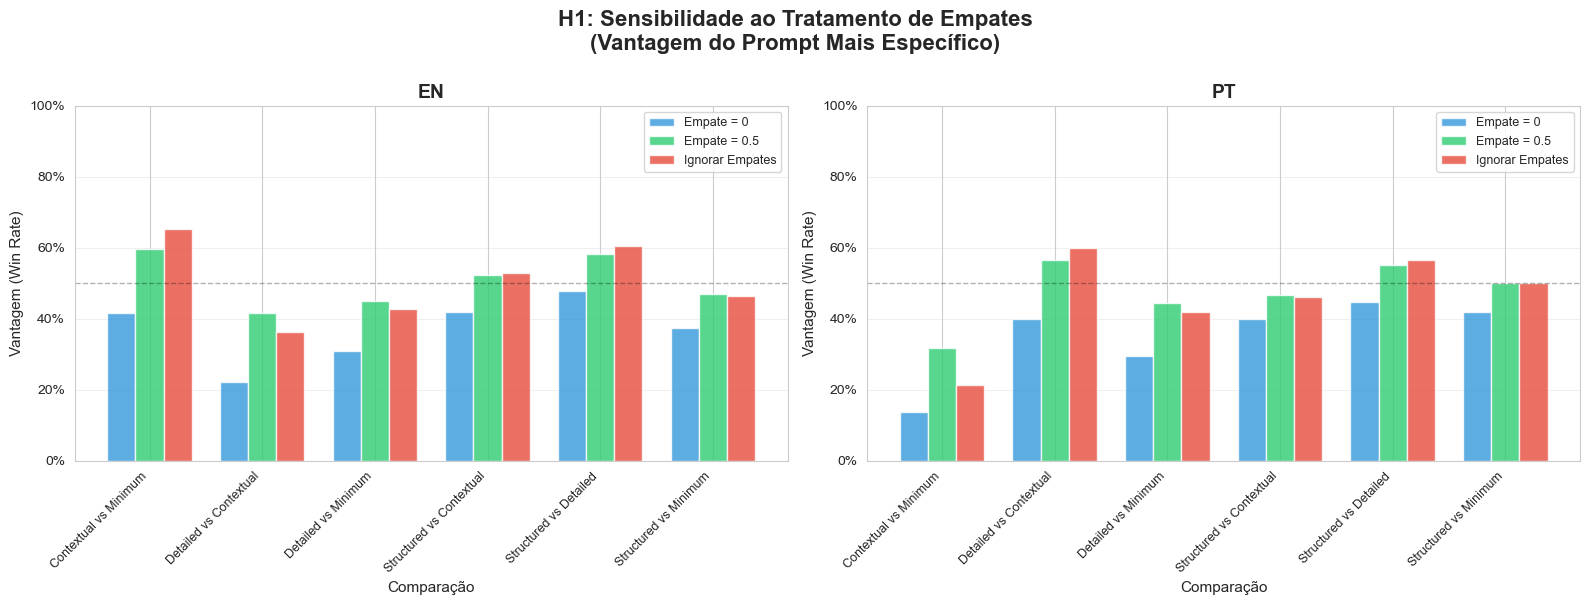

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('H1: Sensibilidade ao Tratamento de Empates\n(Vantagem do Prompt Mais Específico)', 
                fontsize=16, weight='bold', y=1.00)

for ax, lang in zip(axes, ['EN', 'PT']):
    subset = df_sensibilidade[df_sensibilidade['idioma'] == lang].copy()
    subset = subset.sort_values('comparacao')
    
    x = np.arange(len(subset))
    width = 0.25
    
    ax.bar(x - width, subset['empate_como_0'], width, label='Empate = 0', 
            color='#3498db', alpha=0.8, edgecolor='white')
    ax.bar(x, subset['empate_como_0.5'], width, label='Empate = 0.5', 
            color='#2ecc71', alpha=0.8, edgecolor='white')
    ax.bar(x + width, subset['ignorar_empates'], width, label='Ignorar Empates', 
            color='#e74c3c', alpha=0.8, edgecolor='white')
    
    ax.set_title(f'{lang}', fontsize=14, weight='bold')
    ax.set_xlabel('Comparação', fontsize=11)
    ax.set_ylabel('Vantagem (Win Rate)', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(subset['comparacao'], rotation=45, ha='right', fontsize=9)
    ax.axhline(0.5, color='black', linestyle='--', alpha=0.3, linewidth=1)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Variância Intra-Prompt (Índice de Instabilidade)

In [21]:
# --- Criar core_id removendo número da seed do evaluation_id ---
df_prompts['core_id'] = df_prompts['evaluation_id'].apply(lambda x: re.sub(r'_[0-9]+_', '_', x))

In [22]:
def win_rate_intra_prompt(df, prompt, idioma, modelo, coluna_vencedor='gold_winner'):
    subset = df[
        (df['language'] == idioma) &
        (df['model'] == modelo) &
        ((df['prompt_level_of_A'] == prompt) | (df['prompt_level_of_B'] == prompt))
    ]
    
    if len(subset) == 0:
        return pd.Series(dtype=float)
    
    win_rates = []
    grouped = subset.groupby('core_id')
    
    for core_id, group in grouped:
        vitorias = 0
        total = 0
        for _, row in group.iterrows():
            total += 1
            winner = row[coluna_vencedor]
            if winner == 'Tie':
                vitorias += 0.5
            elif winner == 'A' and row['prompt_level_of_A'] == prompt:
                vitorias += 1
            elif winner == 'B' and row['prompt_level_of_B'] == prompt:
                vitorias += 1
        if total > 0:
            win_rates.append(vitorias / total)
    return pd.Series(win_rates)

In [23]:
resultados_variancia = []

for prompt in HIERARQUIA_PROMPTS:
    for idioma in df_prompts['language'].unique():
        for modelo in df_prompts['model'].unique():
            wr = win_rate_intra_prompt(df_prompts, prompt, idioma, modelo)
            if len(wr) > 1:
                resultados_variancia.append({
                    'prompt': prompt.capitalize(),
                    'idioma': idioma.upper(),
                    'modelo': modelo,
                    'n_sample': len(wr),
                    'win_rate_medio': wr.mean(),
                    'desvio_padrao': wr.std(),
                    'coef_variacao': wr.std() / wr.mean() if wr.mean() > 0 else np.nan,
                    'min': wr.min(),
                    'max': wr.max(),
                    'amplitude': wr.max() - wr.min()
                })

df_variancia = pd.DataFrame(resultados_variancia)
df_variancia.head(40)

,prompt,idioma,modelo,n_sample,win_rate_medio,desvio_padrao,coef_variacao,min,max,amplitude
0,Minimum,EN,gemini-1.5-pro-latest,23,0.456522,0.450077,0.985883,0.0,1.0,1.0
1,Minimum,EN,sabia-3.1,28,0.446429,0.398824,0.893367,0.0,1.0,1.0
2,Minimum,EN,gpt-4o,29,0.577586,0.417815,0.723380,0.0,1.0,1.0
3,Minimum,EN,llama-3.3-70b-versatile,39,0.435897,0.416430,0.955340,0.0,1.0,1.0
4,Minimum,PT,gemini-1.5-pro-latest,36,0.590278,0.397100,0.672734,0.0,1.0,1.0
5,Minimum,PT,sabia-3.1,28,0.500000,0.451335,0.902671,0.0,1.0,1.0
6,Minimum,PT,gpt-4o,36,0.520833,0.440677,0.846100,0.0,1.0,1.0
7,Minimum,PT,llama-3.3-70b-versatile,31,0.653226,0.390925,0.598454,0.0,1.0,1.0
8,Contextual,EN,gemini-1.5-pro-latest,27,0.675926,0.391096,0.578607,0.0,1.0,1.0
9,Contextual,EN,sabia-3.1,25,0.520000,0.374444,0.720085,0.0,1.0,1.0


/var/folders/lr/rv52d6g56jbdxpkrbhsvqjzr0000gn/T/ipykernel_84516/168476501.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['prompt'] = pd.Categorical(subset['prompt'], categories=[p.capitalize() for p in HIERARQUIA_PROMPTS], ordered=True)


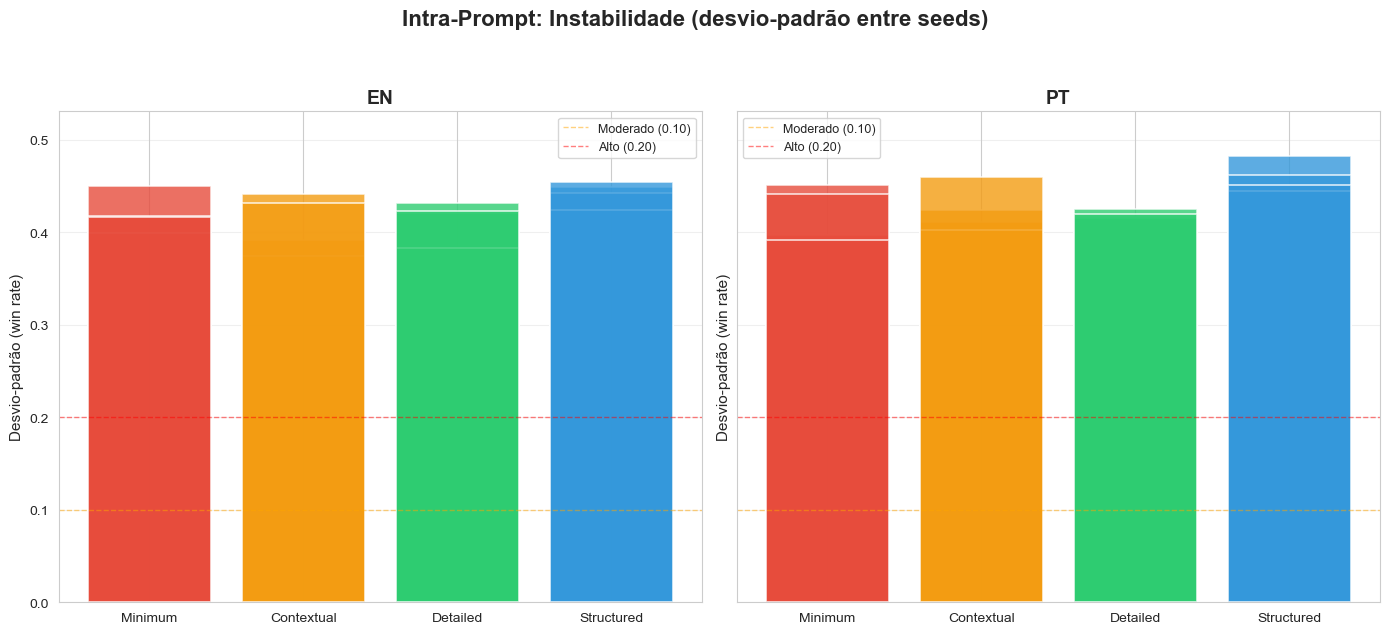

In [24]:
fig, axes = plt.subplots(1, len(df_prompts['language'].unique()), figsize=(14, 6), sharey=True)
fig.suptitle('Intra-Prompt: Instabilidade (desvio-padrão entre seeds)', fontsize=16, weight='bold', y=1.05)

for ax, idioma in zip(axes, df_prompts['language'].unique()):
    subset = df_variancia[df_variancia['idioma'] == idioma.upper()]
    subset['prompt'] = pd.Categorical(subset['prompt'], categories=[p.capitalize() for p in HIERARQUIA_PROMPTS], ordered=True)
    subset = subset.sort_values('prompt')
    
    bars = ax.bar(subset['prompt'], subset['desvio_padrao'],
                  color=[cores_base[p.lower()] for p in subset['prompt']], alpha=0.8, edgecolor='white', linewidth=1.2)
    
    ax.axhline(0.10, color='orange', linestyle='--', alpha=0.5, linewidth=1, label='Moderado (0.10)')
    ax.axhline(0.20, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Alto (0.20)')
    
    ax.set_title(f'{idioma.upper()}', fontsize=14, weight='bold')
    ax.set_ylabel('Desvio-padrão (win rate)', fontsize=11)
    ax.set_ylim(0, max(0.3, subset['desvio_padrao'].max() * 1.1))
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Inter-Prompt - Efeito de Especificidade

In [25]:
def get_winner_prompt(row):
    if row['gold_winner'] == 'A':
        return row['prompt_level_of_A']
    elif row['gold_winner'] == 'B':
        return row['prompt_level_of_B']
    elif row['gold_winner'] == 'Tie':
        return 'Tie'
    else:
        return None


In [26]:
df_prompts['winner_prompt'] = df_prompts.apply(get_winner_prompt, axis=1)

# Win rate médio por nível de prompt e idioma
df_winrate = (
    df_prompts[df_prompts['winner_prompt'] != 'Tie']
    .groupby(['language', 'winner_prompt'])
    .size()
    .reset_index(name='wins')
)

# Total de aparições por prompt (A ou B)
df_counts = pd.concat([
    df_prompts[['language', 'prompt_level_of_A']].rename(columns={'prompt_level_of_A': 'prompt'}),
    df_prompts[['language', 'prompt_level_of_B']].rename(columns={'prompt_level_of_B': 'prompt'})
])
df_counts = df_counts.groupby(['language', 'prompt']).size().reset_index(name='total_appearances')

df_winrate = df_winrate.merge(
    df_counts.rename(columns={'prompt': 'winner_prompt'}),
    on=['language', 'winner_prompt'],
    how='left'
)

df_winrate['win_rate'] = df_winrate['wins'] / df_winrate['total_appearances']

# Ordenar por hierarquia
df_winrate['winner_prompt'] = pd.Categorical(df_winrate['winner_prompt'], categories=HIERARQUIA_PROMPTS, ordered=True)
df_winrate = df_winrate.sort_values(['language', 'winner_prompt'])
df_winrate.head(15)

,language,winner_prompt,wins,total_appearances,win_rate
2,en,minimum,47,131,0.358779
0,en,contextual,47,120,0.391667
1,en,detailed,35,123,0.284553
3,en,structured,60,142,0.422535
6,pt,minimum,61,138,0.442029
4,pt,contextual,35,119,0.294118
5,pt,detailed,35,103,0.339806
7,pt,structured,52,124,0.419355


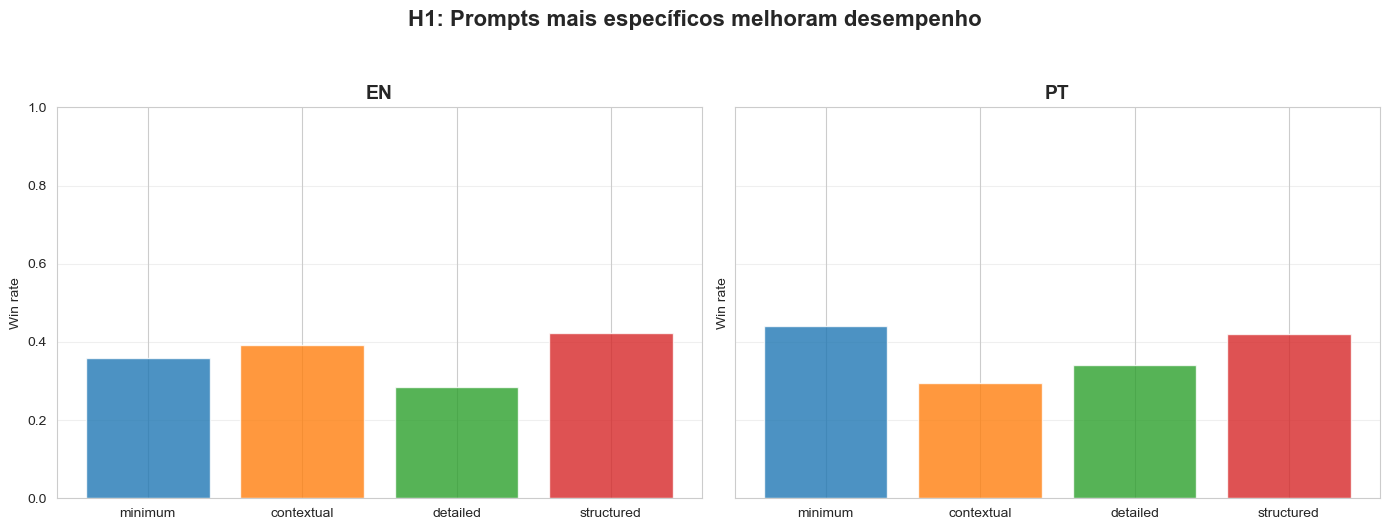

In [27]:
fig, axes = plt.subplots(1, len(df_prompts['language'].unique()), figsize=(14, 5), sharey=True)
fig.suptitle('H1: Prompts mais específicos melhoram desempenho', fontsize=16, weight='bold', y=1.05)

for ax, idioma in zip(axes, df_prompts['language'].unique()):
    subset = df_winrate[df_winrate['language'] == idioma]
    # Cores automáticas para cada barra
    colors = plt.cm.tab10.colors  # 10 cores diferentes
    ax.bar(subset['winner_prompt'], subset['win_rate'], color=colors[:len(subset)], alpha=0.8)
    ax.set_title(idioma.upper(), fontsize=14, weight='bold')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Win rate')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Calcula a taxa de vitória geral de cada nível de prompt (excluindo empates).

**EN:** Structured (42.3%) > Contextual (39.2%) > Minimum (35.9%) > Detailed (28.5%). A ordem não segue a hierarquia de especificidade (Detailed performa pior).

**PT:** Minimum (44.2%) > Structured (41.9%) > Detailed (34.0%) > Contextual (29.4%). A ordem também não segue a hierarquia, e Minimum tem a maior taxa de vitória.

In [28]:
from scipy.stats import kendalltau

for idioma in df_prompts['language'].unique():
    subset = df_winrate[df_winrate['language'] == idioma]
    levels = subset['winner_prompt'].cat.codes
    tau, p = kendalltau(levels, subset['win_rate'])
    print(f"{idioma.upper()}: τ = {tau:.3f}, p = {p:.4f}")


EN: τ = 0.333, p = 0.7500
PT: τ = 0.000, p = 1.0000


Testa se existe uma tendência monotônica (crescente ou decrescente) entre o nível de especificidade e a taxa de vitória.

Os resultados (τ = 0.333, p = 0.75 para EN; τ = 0.000, p = 1.00 para PT) indicam que não há correlação estatisticamente significativa entre a especificidade do prompt e a taxa de vitória em nenhum dos idiomas.

## Modelo Bradley-Terry com Empates (Davidson)

In [29]:
def preparar_dados_btd(df, idioma):
    """
    Prepara dados para o modelo Bradley-Terry-Davidson.
    Formato: matriz de contagens [i vence j, empates, j vence i]
    """
    prompts = HIERARQUIA_PROMPTS
    n = len(prompts)
    
    # Inicializa matrizes
    vitorias = np.zeros((n, n))  # vitorias[i,j] = quantas vezes i venceu j
    empates_mat = np.zeros((n, n))  # empates[i,j] = empates entre i e j
    comparacoes = np.zeros((n, n))  # total de comparações
    
    for i, p_i in enumerate(prompts):
        for j, p_j in enumerate(prompts):
            if i == j:
                continue
            
            # Filtra comparações entre p_i e p_j
            subset = df[
                (df['language'] == idioma) &
                (((df['prompt_level_of_A'] == p_i) & (df['prompt_level_of_B'] == p_j)) |
                    ((df['prompt_level_of_A'] == p_j) & (df['prompt_level_of_B'] == p_i)))
            ]
            
            for _, row in subset.iterrows():
                winner = row['gold_winner']
                comparacoes[i, j] += 1
                
                if winner == 'Tie':
                    empates_mat[i, j] += 1
                elif winner == 'A':
                    if row['prompt_level_of_A'] == p_i:
                        vitorias[i, j] += 1
                    else:
                        vitorias[j, i] += 1
                elif winner == 'B':
                    if row['prompt_level_of_B'] == p_i:
                        vitorias[i, j] += 1
                    else:
                        vitorias[j, i] += 1
    
    return vitorias, empates_mat, comparacoes


In [30]:
def estimar_forca_btd(vitorias, empates, max_iter=1000, tol=1e-6):
    """
    Estima forças usando modelo Bradley-Terry-Davidson (com empates).
    
    Usa algoritmo iterativo de máxima verossimilhança.
    """
    n = vitorias.shape[0]
    
    # Inicializa forças (log-scale para estabilidade numérica)
    log_lambda = np.zeros(n)
    
    for iteracao in range(max_iter):
        log_lambda_old = log_lambda.copy()
        
        # Atualiza cada força
        for i in range(n):
            numerador = 0
            denominador = 0
            
            for j in range(n):
                if i == j:
                    continue
                
                n_ij = vitorias[i, j] + vitorias[j, i] + empates[i, j]
                if n_ij == 0:
                    continue
                
                # Probabilidades do modelo Davidson
                lambda_i = np.exp(log_lambda[i])
                lambda_j = np.exp(log_lambda[j])
                
                # P(i vence j) = lambda_i / (lambda_i + lambda_j + nu * sqrt(lambda_i * lambda_j))
                # Para simplificar, assumimos nu=1 (parâmetro de empate)
                nu = 1.0
                denom_ij = lambda_i + lambda_j + nu * np.sqrt(lambda_i * lambda_j)
                
                # Contribuição para o numerador (vitórias de i sobre j)
                numerador += vitorias[i, j]
                
                # Contribuição para o denominador
                denominador += n_ij * lambda_i / denom_ij
        
        if denominador > 0:
            log_lambda[i] = np.log(numerador / denominador)
        
        # Normaliza para que a soma seja 0 (identificabilidade)
        log_lambda -= log_lambda.mean()
        
        # Verifica convergência
        if np.max(np.abs(log_lambda - log_lambda_old)) < tol:
            print(f"  Convergência alcançada em {iteracao+1} iterações")
            break
    
    # Converte de volta para escala original
    forcas = np.exp(log_lambda)
    forcas = forcas / forcas.sum()  # Normaliza para somar 1
    
    return forcas

In [31]:
resultados_btd = []

for lang in ['en', 'pt']:
    print(f"\n{lang.upper()}:")
    vitorias, empates, comparacoes = preparar_dados_btd(df_prompts, lang)
    
    print(f"  Total de comparações: {int(comparacoes.sum()/2)}")
    print(f"  Total de empates: {int(empates.sum()/2)}")
    
    # Estima forças
    forcas = estimar_forca_btd(vitorias, empates)
    
    for i, prompt in enumerate(HIERARQUIA_PROMPTS):
        resultados_btd.append({
            'prompt': prompt.capitalize(),
            'idioma': lang.upper(),
            'forca_btd': forcas[i],
            'rank': len(HIERARQUIA_PROMPTS) - np.argsort(np.argsort(forcas))[i]
        })

df_btd = pd.DataFrame(resultados_btd)


EN:
  Total de comparações: 258
  Total de empates: 69
  Convergência alcançada em 9 iterações

PT:
  Total de comparações: 242
  Total de empates: 59
  Convergência alcançada em 9 iterações


In [32]:
print(f"\n{'─'*80}")
print("FORÇAS ESTIMADAS (Bradley-Terry-Davidson):\n")
df_print_btd = df_btd.copy()
df_print_btd['forca_btd'] = df_print_btd['forca_btd'].map('{:.4f}'.format)
df_print_btd.head(10)



────────────────────────────────────────────────────────────────────────────────
FORÇAS ESTIMADAS (Bradley-Terry-Davidson):



,prompt,idioma,forca_btd,rank
0,Minimum,EN,0.2312,4
1,Contextual,EN,0.2312,3
2,Detailed,EN,0.2312,2
3,Structured,EN,0.3063,1
4,Minimum,PT,0.2331,4
5,Contextual,PT,0.2331,3
6,Detailed,PT,0.2331,2
7,Structured,PT,0.3008,1


In [33]:
print("INTERPRETAÇÃO:")
print("  - Forças somam 1.0 dentro de cada idioma")
print("  - Maior força = maior probabilidade de vencer comparações")
print("  - Rank 1 = prompt mais forte")

INTERPRETAÇÃO:
  - Forças somam 1.0 dentro de cada idioma
  - Maior força = maior probabilidade de vencer comparações
  - Rank 1 = prompt mais forte


Estima uma "força" relativa para cada prompt, considerando todas as comparações par a par e incluindo empates.

Resultados: Em ambos os idiomas, o prompt Structured aparece como o mais forte (maior força e Rank 1). No entanto, os outros três prompts (Minimum, Contextual, Detailed) têm forças muito similares entre si e consideravelmente menores que Structured.

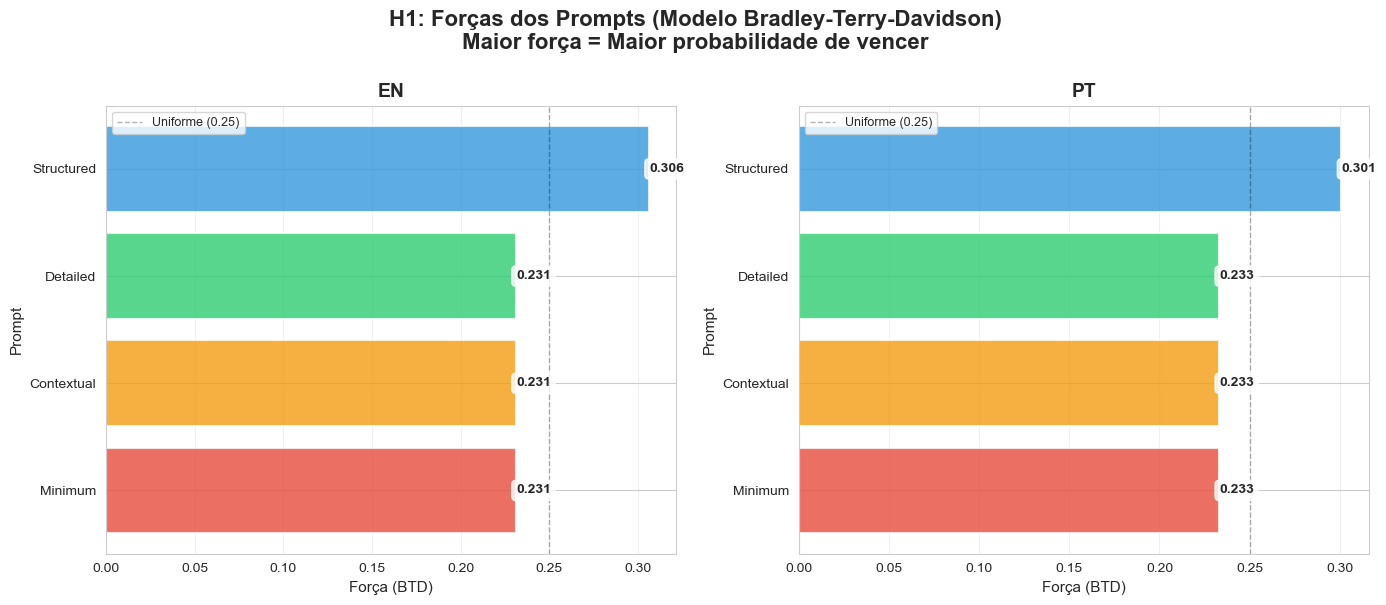

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('H1: Forças dos Prompts (Modelo Bradley-Terry-Davidson)\nMaior força = Maior probabilidade de vencer', 
                fontsize=16, weight='bold', y=1.00)

for ax, lang in zip(axes, ['EN', 'PT']):
    subset = df_btd[df_btd['idioma'] == lang].sort_values('forca_btd', ascending=True)
    
    colors = [cores_base[p.lower()] for p in subset['prompt']]
    bars = ax.barh(subset['prompt'], subset['forca_btd'], 
                    color=colors, alpha=0.8, edgecolor='white', linewidth=1.5)
    
    # Linha de referência (força uniforme = 1/4 = 0.25)
    ax.axvline(0.25, color='black', linestyle='--', alpha=0.3, linewidth=1, label='Uniforme (0.25)')
    
    ax.set_title(f'{lang}', fontsize=14, weight='bold')
    ax.set_xlabel('Força (BTD)', fontsize=11)
    ax.set_ylabel('Prompt', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(axis='x', alpha=0.3)
    
    # Adiciona valores nas barras
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{width:.3f}',
                ha='left', va='center', fontsize=10, weight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## Conclusão para a Hipótese H₁:

A análise dos dados não suporta a Hipótese H₁. Não há evidência consistente nos dados apresentados de que prompts mais específicos melhoram o desempenho de forma monotônica (ou seja, seguindo a ordem minimum < contextual < detailed < structured) em ambos os idiomas.

* As comparações diretas par a par não mostram o prompt mais específico vencendo na maioria das vezes.

* As taxas de vitória gerais por prompt não seguem a ordem de especificidade esperada em nenhum dos idiomas.

* O teste de correlação de Kendall Tau falha em encontrar uma tendência estatisticamente significativa.

* Embora o modelo BTD aponte Structured como o mais forte, ele não diferencia claramente os outros três níveis, falhando em confirmar a hierarquia completa da hipótese.

* A alta taxa de empates sugere que as diferenças entre os níveis de prompt podem não ser sempre perceptíveis ou significativas.

* A análise de variância intra-prompt mostra desvios padrão relativamente altos, indicando que a performance de um mesmo nível de prompt pode variar consideravelmente entre diferentes execuções (sample_n), o que pode esconder as diferenças entre os níveis.